<a href="https://colab.research.google.com/github/aminehd/AminehTechnicalWritings/blob/main/notebookes/LinearRegressionMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Outline
- Load data in repo
- Introduction (Purpose + scope)
- Body
  - Statistic:
    - Population vs sample
    - Assumptions about population: Error terms has a normal distribution. But what's error term?
    - Assumptions about sample: But didn't we talk about assumptions about population?
    - Why $\widehat{\beta}$ and not just $\beta$
    - Visualize the assumptions: line fitting
  - Transition from intuitive descriptions to mathematical formulation
    
  - Linear Algebra
     - Linear regression is solving linear equations.
     - Matrix notation for solving linear equations.
     - Design matrix for given Sample
     - How to deal with uncertainty: Error term again.
     - Find regression coefficient in term of responses and design matrix.
     - How does it look like. Fit the line!
 - Probability:
    - how to motivate the cost function.

- Conclusion:
- Appendix: Some linear algebra
  - questions
  - switch to another view: column space
  - revisit two questions
  - Go back a bit, what if no solution, what about projection ...
  - rank of X, stuff about the projecting
  - what if it has solution


##Git Setup

In [ ]:
import google.colab
repo_path = 'AminehTechnicalWritings'
!git -C $repo_path pull origin || git clone https://github.com/aminehd/AminehTechnicalWritings/ $repo_path
local_clone = '/content/' + repo_path
!git config --global user.email "amineh.dadsetan@gmail.com"
!git config --global user.name "Amineh Dadsetan"

fatal: cannot change to 'AminehTechnicalWritings': No such file or directory
Cloning into 'AminehTechnicalWritings'...
remote: Enumerating objects: 497, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 497 (delta 3), reused 0 (delta 0), pack-reused 487
Receiving objects: 100% (497/497), 3.83 MiB | 7.68 MiB/s, done.
Resolving deltas: 100% (312/312), done.


### Git Setup
To push to your personal repo,
1. go to https://github.com/settings/tokens
2. generate a token with all access
3. run `git push https://<token>@github.com/yourusername/yourrepository.git`
( `git push https://<token>@github.com/aminehd/AminehTechnicalWritings.git`)

In [ ]:
%load_ext autoreload
%autoreload 2
# Import utility functions that provide answers to challenges
%load_ext autoreload


import sys
sys.path.insert(1, '/content/AminehTechnicalWritings/src')

%aimport sampling_utils

import sampling_utils as su
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
population = su.get_population(local_clone + '/data/population.npz')
population.shape

(300000, 2)

## Introduction
In this notebook, I would like to go through the linear regression concepts. There are several books that has an introduction of this topic.

Usually the tutorial begins with  statistics concepts like understanding **predictors** and **response**, withe aim to train from a **sample** data set.
It is followed by the introduction of matrix notations and loss function.
 Ocasionally, at the end, there might be a word or two on how Maximum liklihood or Best Linear Unbiased Estimator  is relevent to the subject.


So you see, it starts with statistics, then turns to linear algebra and some analysis, and finally a lot of probability that sounds very uncalled for. I found this super annoying because sometime you just wanna learn linear regression, and not statistic, linear algebra and probability (specially if it is on a weekend).

In this notebook, I attempt to teach the linear regression, while separating all this major ideas that comes out of  different fields of study. Specifically, I break it down to $\textbf{Statistical}$ concepts, $\textbf{Linear algebraic}$ concepts and $\textbf{Probability}$.

 I also try to implement python function that serves as a mechanism to talk about all this mathematical abstractions. My hope is to give the audience tools to answer their questions about all this concepts using the python utilities .
 Some Important nots: I am reading standford book called [ISLP](https://www.statlearning.com/) which is great textbook. Hence I am using their terminologies. This notebook can be used by people who are reading the ISLP book to clarify any confusion.






## Statistics

What is statistics? That's the only way I can start a pargraph that is about statistics. The reason is that I am not really sure what statistics is. Specially I don't know what is the difference of statistics and probability theory. The good news is that I still know what is difference of statistics and linear algebra, but still it is not enough knowledge to help write a chapter about statistics.

[Wikipedia](https://en.wikipedia.org/wiki/Statistics) says:
> Statistics is the discipline that concerns the collection, organization, analysis, interpretation, and presentation of data. In applying statistics to a scientific, industrial, or social problem, it is conventional to begin with a statistical population or a statistical model to be studied.



As the text says,in applying statistics, it is conventional to begin with a statistical population, or model. By the way that is exactly what I wanted to hear.

Perhaps statistics is a lot about practicality. We have a population of people. Then we wanna represent them as a set of datapoints.Each datapoint contains **predictors** or $x$'s and **responses** or $y$'s. An example of predictor can be age and example of response (or predicted) can be how much debt they have.

The **model** concern is about how to relate y to x across all data points. Model is a mathematical formula with x and y that is not exactly a mathematical formula mainly because mathematical formulas don't have uncertainty but real world populations are.

\- What is **Sample**? It is a smaller subset of population? \\
\+ Why? \\
\- Mainly because practical concerns. Population can be as big as the population of a whole country. Whatever purpose you have, it is easier to be done on a smaller group of the population which we call sample.

Only things you need to remember from this section is **Population**, **Sample**, **predictor**, **response**, **Population vs Sample**.  



### Population VS Sample 🆚
I think the key point to understand linear regression and methods built around it, is to pause and think about difference of **populataion data set** and a given **sample data set**. Let's play around with the two concept with our data. ⏸

I have wrote some utility function that helps you build a sampler around given population.
Once you built a sampler from population, you can fix the set of predictors (`set_sample_xs`). Finally you can use `sample_response` to sample `y`s with replacement.
You can think of it as a experiment in which the predictor is age and outcome is their credit score. Before starting the experminet you know how many people and from what ages you would like to run experiment on. Just knowing the ages (predictor) is not enought since there is so many people with same age thus so many credit scores (response) that can be used as training set.  So what you need to do is to sample actual people of the given ages to study their credit scores.




In [ ]:

sampler = su.PopulationSampler(population)
x_samp_index, x_samples = sampler.set_sample_xs(100)
resp = np.array(list(sampler.sample_random_response()))
x, y = resp[:, 0], resp[:, 1]


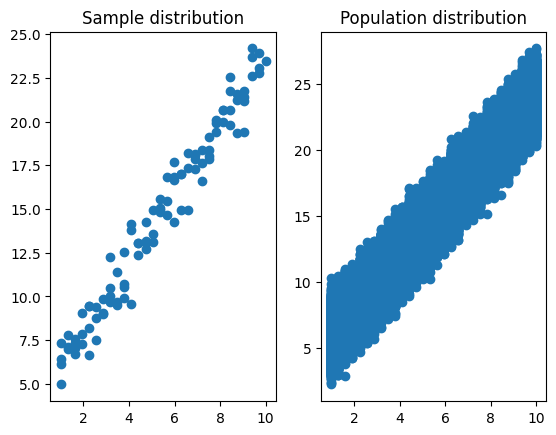

In [ ]:
fix, axes = plt.subplots(ncols=2)
# sample[:,0], sample[:,1]
axes[0].scatter(x, y)
axes[0].set_title('Sample distribution')
axes[1].set_title('Population distribution')
axes[1].scatter(population[:,0], population[:,1]);


### Assumptions about population: Error terms has a normal distribution:


In simple terms, the assumption of linear regression for a population data set is that when you plot the responses against the predictors, the points will generally cluster around a straight line that runs through the data.

You can see it in the generated population data. Notice the red line passing through blue datapoints.


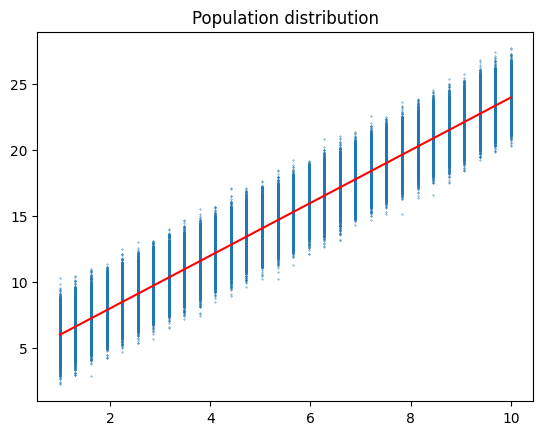

In [ ]:
fix, axe = plt.subplots()

axe.scatter(population[:,0], population[:,1], s=0.1);
axe.set_title('Population distribution')
axe.plot(np.unique(population[:,0]), np.unique(population[:,0]) * 2 + 4, color='r');


To formalize the hell out of it, we need to refer to the linear combination of the predictors and to something called error term.  

More precisely,   subtract a linear combination of predictors from the response, the result is called error term, and based on our *assumption* it has a standard normal distribution.

Finding the red line is to fit a linear model.








### Assumptions about sample: But didn't we talk about assumptions about population?
In many practical situations, the whole population is too big and mostly unknown to us. It is not possible to count every object in the population, so the computation must be performed on a sample of the population.

One issue working with sample as a proxy of the population, is that we can not make direct assumption about the sample like we do for the population. Specifically, how do we know that the sample follows the assumption of linear regression as well? What if the sample data set is a horrible representetive of population data set and not random at all?

Let's pick a sample set of size 100 with lowest responses among datapoints with the same predictor (dots in red).  
Next  I randomly pick 100 datapoints (in yellow) and finally I pick 100 datapoints with highest responses (in green).

Notice the graph of three different sampling and how the results can be so dramatically different, depending in how high or low we sample responses are.






In [ ]:
# lowest resps for given x
x_samp_index, x_samples = sampler.set_sample_xs(100)
resp = np.array(list(sampler.sample_lowest_responses()))
x, y_lowest = resp[:, 0], resp[:, 1]

# highest resps for given x
x_samp_index, x_samples = sampler.set_sample_xs(100)
resp = np.array(list(sampler.sample_highest_responses()))
x, y_highest = resp[:, 0], resp[:, 1]

# random resp for given x
x_samp_index, x_samples = sampler.set_sample_xs(100)
resp = np.array(list(sampler.sample_random_response()))
x, y_random = resp[:, 0], resp[:, 1]

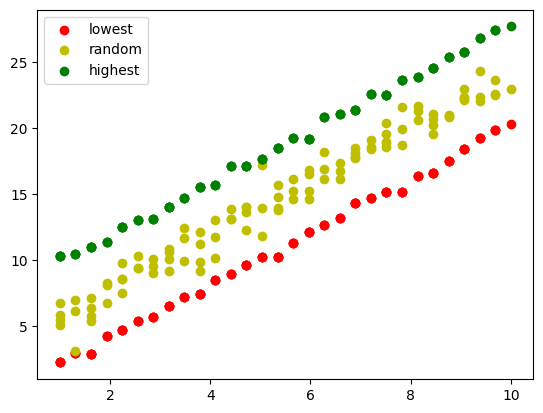

In [ ]:
fig, axes = plt.subplots(ncols=1)
ax0 = axes
ax0.scatter(x, y_lowest, color='r')
ax0.scatter(x, y_random, color='y')
ax0.scatter(x, y_highest, color='g')
ax0.legend(['lowest', 'random', 'highest'])
# ax0.set_title('Sample distribution')
# ax[1].set_title('Population distribution')
# ax[1].scatter(population[:,0], population[:,1]);

Here!!! develop a Population class that let's add predictor, change response, partition responses based on preds...


In the above graph, there are three sample sets: green with the highest responses, red with the lowest responses, and yellow, which is sampled with replacement. Visually, they appear different. To discuss their differences more accurately, we can also compute [sample statistics](<https://en.wikipedia.org/wiki/Statistic>) for each sample.

Sample mean is a good sample statistic we can talk about. The sample mean for green sample is --, for yellow in --- and for red is ---, while population mean is ---. You can see sample mean for green and red sample are higher and lower than sample population, respectively. Also the samle mean for the yellow one is close to the population mean.  (HERE!!! fill numbers)

There are ${m \choose 100}$ ways to pick a sample of size 100, where 'm' is the size of the population. Therefore, we get ${m \choose 100}$ sample means for the given size. This yields a decent  number of data points. This gives us a [sampling distribution](<https://en.wikipedia.org/wiki/Sampling_distribution>) of the sample mean. Hopefully all this setup will make you feel an urge to graph the sample means:
 HERE!!! (do the graph)



In [ ]:
# HERE!!!!! graph sample means

The way to ensure, is to sample with replacement. It means we don't sample just once, we sample a lot of times so in essence we don't have just one sample but many.  Subsequently, we can think about  [sampling distribution](https://en.wikipedia.org/wiki/Sampling_distribution) over all possible samples.

Take any statistics (a measure on a set), such as sample mean, and think about what would be the all possible outcomes over all samplings. That would give you a distribution again. Thus you can say stuff about the variance of it (see [sample Variance ](https://en.wikipedia.org/wiki/Variance#Sample_variance). Knowing such variance you can measure how much it might deviate (see [standard error](https://en.wikipedia.org/wiki/Standard_error)).

Finally, if you fit the model for the sample, and not for the population, you can calculate the [variance of the predicted response](https://en.wikipedia.org/wiki/Variance_of_the_mean_and_predicted_responses). I talk about it more in the  [next notebook](https://colab.research.google.com/github/aminehd/AminehTechnicalWritings/blob/main/notebookes/LinearRegressionMatrix.ipynb#scrollTo=cwhNfPNNkFAH) ). (HERE!!! add the example about the sample mean HERE!!!!) (HERE!!!! link to next notebook) .




Let's turn our focus to the case that we wanna calculate the regression coefficient for a given sample. We develop a simple algorithm and then we talk about how reasonable our algorithm is  by inspecting how good the predictions are.





Second consequence $\widehat{\beta}$. HERE!!!!! go to linear algebra


 Add utilities to create population (add features to them...) HERE!!!!!